In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
#import pyvista as pv
#from skimage.filters import gaussian
#from scipy.ndimage import zoom, center_of_mass, shift, affine_transform
#from scipy import ndimage as ndi
#from scipy.spatial import procrustes
#from scipy.spatial.transform import Rotation as R
#import cv2
import SimpleITK as sitk
#import ipywidgets
from pathlib import Path
from tqdm import tqdm
#from collections import Counter
#import warnings
#warnings.filterwarnings("ignore")
#"ipyvtklink", "panel", "ipygany", "static", "pythreejs", "client", "server", "trame", "none"
#pv.set_jupyter_backend("panel")

In [ ]:
#%load_ext autoreload
#%autoreload 2

In [4]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
from library.atlas.atlas_utilities import register_volume, adjust_volume, \
    affine_transform_point, resample_image, load_transformation, get_min_max_mean, \
    numpy_to_sitk, groupwise_registration

from library.controller.sql_controller import SqlController


/home/eddyod/programming/pipeline/src


In [3]:
def visualize_slices(volume, title="Slice View"):
    """Visualize the middle slices of a 3D volume."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [s // 2 for s in volume.shape]
    
    axes[0].imshow(volume[mid_slices[0], :, :], cmap='gray')
    axes[0].set_title("Axial Slice")
    axes[1].imshow(volume[:, mid_slices[1], :], cmap='gray')
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(volume[:, :, mid_slices[2]], cmap='gray')
    axes[2].set_title("Sagittal Slice")
    
    for ax in axes:
        ax.axis("on")
    plt.suptitle(title)
    plt.show()

In [36]:
def resize_image(image, new_size):
    """
    Resamples an image to match the reference image in size, spacing, and direction.
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)  # Linear interpolation for resampling
    resampler.SetDefaultPixelValue(0)  # Fill with zero if needed
    resultImage = resampler.Execute(image)
    #return sitk.GetArrayFromImage(resultImage)
    return resultImage

def center_images_to_largest_volume(images):
    """
    Centers a list of 3D SimpleITK images using the largest-volume image as the reference.

    Parameters:
        images (List[sitk.Image]): List of 3D SimpleITK Image objects.

    Returns:
        List[sitk.Image]: List of centered images (same order as input).
    """
    if not images:
        raise ValueError("No images provided.")

    # Compute volumes and find reference image
    volumes = [img.GetSize()[0] * img.GetSize()[1] * img.GetSize()[2] * 
               img.GetSpacing()[0] * img.GetSpacing()[1] * img.GetSpacing()[2] for img in images]
    reference_index = volumes.index(max(volumes))
    reference_image = images[reference_index]

    centered_images = []
    for i, img in enumerate(images):
        if i == reference_index:
            centered_images.append(img)
            continue

        # Calculate center transform
        try:
            transform = sitk.CenteredTransformInitializer(reference_image, img,
                                                        sitk.Euler3DTransform(), 
                                                        sitk.CenteredTransformInitializerFilter.GEOMETRY)
        except Exception as e:
            print(f"Error initializing transform for image {i}: {e}")
            exit(1)

        # Resample image
        resampled = sitk.Resample(img,
                                  reference_image,
                                  transform,
                                  sitk.sitkLinear,
                                  0.0,
                                  img.GetPixelID())

        centered_images.append(resampled)

    return centered_images


def align_images_to_common_center(images):
    """
    Given a list of SimpleITK 3D images, return a list of translated images
    aligned to their common center.
    """
    centers = [get_image_center(img) for img in images]
    common_center = np.mean(centers, axis=0)
    
    aligned_images = []

    for img, center in zip(images, centers):
        transform = compute_translation_transform(center, common_center)
        resampled = sitk.Resample(
            img,
            img.GetSize(),
            transform,
            sitk.sitkLinear,
            img.GetOrigin(),
            img.GetSpacing(),
            img.GetDirection(),
            0.0,  # default pixel value
            img.GetPixelID()
        )
        aligned_images.append(resampled)
    
    return aligned_images

def get_image_center(image):
    """Compute the physical center of a SimpleITK image."""
    size = np.array(image.GetSize())
    spacing = np.array(image.GetSpacing())
    origin = np.array(image.GetOrigin())
    direction = np.array(image.GetDirection()).reshape(3, 3)
    
    center_index = (size - 1) / 2.0
    center_physical = origin + direction @ (center_index * spacing)
    
    return center_physical

def compute_translation_transform(from_center, to_center):
    """Create a translation transform that moves from_center to to_center."""
    translation_vector = to_center - from_center
    return sitk.TranslationTransform(3, translation_vector)


def average_volume(volumes):
    images = [sitk.GetImageFromArray(img.astype(np.float32)) for img in volumes]
    """
    reference_image = max(images, key=lambda img: np.prod(img.GetSize()))
    resampled_images = [resample_image(img, reference_image) for img in images]
    #registered_images = [register_volume(img, reference_image, iterations, default_pixel_value) for img in resampled_images if img != reference_image]
    resampled_images = center_images_to_largest_volume(resampled_images)

    registered_images = [sitk.GetArrayFromImage(img) for img in resampled_images]
    avg_array = np.mean(registered_images, axis=0)
    print(f"Average image shape: {avg_array.shape} min: {np.min(avg_array)} max: {np.max(avg_array)}")
    """

    sizes = [img.GetSize() for img in images]
    max_size = np.max(sizes, axis=0)

    images = [resize_image(img, max_size.tolist()) for img in images]
    #resampled_images = center_images_to_largest_volume(images)
    resampled_images = align_images_to_common_center(images)
    avg_volume = np.mean([sitk.GetArrayFromImage(vol) for vol in resampled_images], axis=0)
    return avg_volume



In [39]:
structure = '7n_L'

In [52]:
volumes = []
brains = ['MD585', 'MD589', 'MD594']
brains = ['AtlasV8']

for brain in brains:
    structure_dir = os.path.join(data_path, brain, 'structure')
    structures = sorted(os.listdir(structure_dir))
    for structure in structures:
        structure_path = os.path.join(structure_dir, structure)
        arr = np.load(structure_path)
        #affine = convert_euler(brain)
        #arr = affine_transform_volume(arr, affine)
        #volumes.append(arr)
        ids = np.unique(arr)
        print(f'{brain} {arr.dtype} {len(ids)} {structure_path}')

AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/10N_L.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/10N_R.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/12N.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/3N_L.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/3N_R.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/4N_L.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/4N_R.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/5N_L.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/5N_R.npy
AtlasV8 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/AtlasV8/structure/6N_L.npy
AtlasV8 uint8 2 /net/birdstor

In [41]:
avg_volume = average_volume(volumes)
print(avg_volume.shape, avg_volume.dtype)
#ids, counts = np.unique(avg_volume, return_counts=True)
#print(ids)
#print(counts)

(120, 126, 128) float32


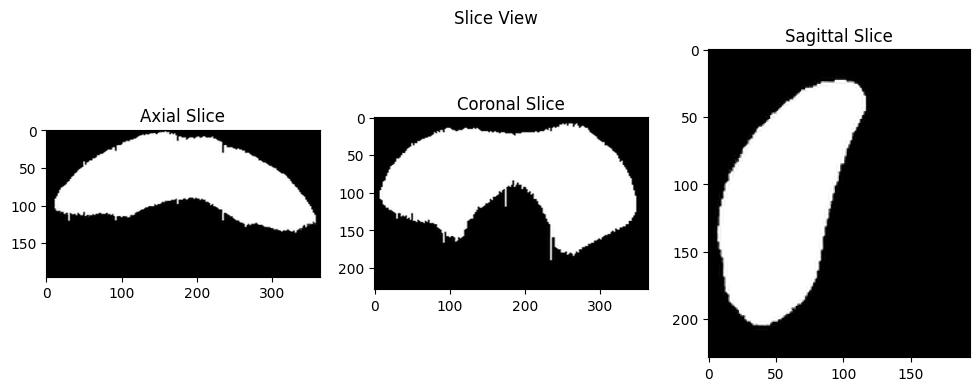

In [29]:
visualize_slices(avg_volume)

In [ ]:
allen_id = 255
#arr = volumes[0]
volume = consensus.copy()
z = volume.shape[2] // 2
print('midpoint=',z)
#volume = adjust_volume(volume, 255)
#volume = gaussian(volume, 4.0)            
upper = np.quantile(volume, 0.75)
print('upper', upper)
#upper = 100
print(np.mean(volume), np.min(volume), np.max(volume))
#volume[(volume > upper) ] = allen_id
#volume[(volume != allen_id)] = 0
#volume = volume.astype(np.uint32)

slice = volume[:,:,z]
plt.imshow(slice, cmap='gray')

In [ ]:
animals = ['MD585','MD589', 'MD594', 'AtlasV8']
structure = 'SC'

for animal in animals:
    structure_path = os.path.join(data_path, animal, 'structure', f'{structure}.npy')
    origin_path = os.path.join(data_path, animal, 'origin', f'{structure}.txt')
    com_path = os.path.join(data_path, animal, 'com', f'{structure}.txt')

    com = np.loadtxt(com_path)
    origin = np.loadtxt(origin_path)
    arr = np.load(structure_path)
    ids, counts = np.unique(arr, return_counts=True)
    if len(ids) == 1:
        print(animal, 'com', com, 'origin', origin)
        print('volume is all black')
        print(arr.shape, arr.dtype, np.mean(arr), np.min(arr), np.max(arr))